Loan Default Prediction

In [7]:
# Clean rewrite of train_logreg_full.py without escape errors
script_fixed = """
#!/usr/bin/env python3
import os, json, zipfile, argparse
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
                             classification_report, confusion_matrix)
import joblib

def load_csv_from_zip(zip_path, csv_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_name) as f:
            return pd.read_csv(f)

def plot_and_save_roc_pr(y_test, y_proba, outdir):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], '--', linewidth=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    roc_path = os.path.join(outdir, 'roc_curve.png')
    plt.tight_layout()
    plt.savefig(roc_path)
    plt.close()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AP = {ap:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    pr_path = os.path.join(outdir, 'pr_curve.png')
    plt.tight_layout()
    plt.savefig(pr_path)
    plt.close()
    return roc_path, pr_path

def main(args):
    zip_path = args.zip
    csv_name = args.csvname
    outdir = args.outdir
    target_col = args.target
    top_k = args.top_k
    test_size = args.test_size
    random_state = args.random_state
    max_iter = args.max_iter

    Path(outdir).mkdir(parents=True, exist_ok=True)
    print("Loading data...", zip_path, csv_name)
    df = load_csv_from_zip(zip_path, csv_name)
    print("Rows, cols:", df.shape)

    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found.")
    if df[target_col].dtype == object:
        df[target_col] = df[target_col].astype(str).str.strip().str.lower().map(
            lambda x: 1 if x in ('1','true','yes','default','charged off','y') else 0)

    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

    for c in list(cat_cols):
        if df[c].nunique(dropna=True) > top_k:
            top_vals = df[c].value_counts().nlargest(top_k).index
            df[c] = df[c].where(df[c].isin(top_vals), other='__OTHER__')

    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

    print('Num cols:', len(num_cols), 'Cat cols:', len(cat_cols))
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=y, random_state=random_state)
    print('Train/Test:', X_train.shape, X_test.shape)

    num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
    cat_pipe = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='missing')),
                         ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
    preproc = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], sparse_threshold=0)
    clf = Pipeline([('preproc', preproc),
                    ('clf', LogisticRegression(solver='saga', max_iter=max_iter, class_weight='balanced'))])

    print('Fitting model...')
    clf.fit(X_train, y_train)
    print('Fitted.')

    y_proba = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred, output_dict=True)

    metrics = {'roc_auc': float(roc_auc),
               'average_precision': float(ap),
               'confusion_matrix': cm.tolist(),
               'classification_report': clf_report}
    with open(os.path.join(outdir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=2)

    roc_path, pr_path = plot_and_save_roc_pr(y_test, y_proba, outdir)

    model_path = os.path.join(outdir, 'logreg_pipeline.joblib')
    joblib.dump(clf, model_path, compress=3)

    try:
        pre = clf.named_steps['preproc']
        ohe = None
        if len(cat_cols) > 0:
            ohe = pre.named_transformers_['cat'].named_steps['ohe']
            cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
        else:
            cat_feature_names = []
        feature_names = list(num_cols) + cat_feature_names
        coefs = clf.named_steps['clf'].coef_[0]
        if len(feature_names) == len(coefs):
            coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
            coef_df['abs_coef'] = coef_df['coef'].abs()
            coef_df = coef_df.sort_values('abs_coef', ascending=False)
            coef_df.to_csv(os.path.join(outdir, 'top_coeffs.csv'), index=False)
    except Exception as e:
        print("Could not extract coefficients:", e)

    print('Done. Results in', outdir)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--zip', required=True)
    parser.add_argument('--csvname', default='Loan_Default.csv')
    parser.add_argument('--outdir', default='outputs')
    parser.add_argument('--target', default='Status')
    parser.add_argument('--top_k', type=int, default=50)
    parser.add_argument('--test_size', type=float, default=0.2)
    parser.add_argument('--random_state', type=int, default=42)
    parser.add_argument('--max_iter', type=int, default=2000)
    args = parser.parse_args()
    Path(args.outdir).mkdir(parents=True, exist_ok=True)
    main(args)
"""
with open("train_logreg_full.py", "w", encoding="utf-8") as f:
    f.write(script_fixed)
print("✅ Fixed script written: train_logreg_full.py")


✅ Fixed script written: train_logreg_full.py


In [8]:
# In a notebook cell (prefix with ! to run shell command)
ZIP_PATH= r"D:\Loan_Default_prediction\data\Loan_Default.csv.zip"   # <-- change if your zip is elsewhere
CSV_NAME="Loan_Default.csv"
OUTDIR= r"D:\Loan_Default_prediction\outputs"
# Increase top_k if you want more categories; reduce if you want fewer features
TOP_K=50
MAX_ITER=3000

# run script (this executes outside the kernel process but prints stdout to the cell)
!python train_logreg_full.py --zip "$ZIP_PATH" --csvname "$CSV_NAME" --outdir "$OUTDIR" --target "Status" --top_k $TOP_K --max_iter $MAX_ITER


Loading data... D:\Loan_Default_prediction\data\Loan_Default.csv.zip Loan_Default.csv
Rows, cols: (148670, 34)
Num cols: 11 Cat cols: 21
Train/Test: (118936, 32) (29734, 32)
Fitting model...
Fitted.
Done. Results in D:\Loan_Default_prediction\outputs


ROC AUC: 0.8674082822773999
Average Precision: 0.7991069245491025
Confusion matrix: [[19740, 2666], [2122, 5206]]
Precision/Recall/F1 for class 1: {'precision': 0.6613313008130082, 'recall': 0.7104257641921398, 'f1-score': 0.685}


array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

,feature,coef,abs_coef
0,credit_type_EQUI,6.446334,6.446334
1,credit_type_EXP,-1.966045,1.966045
2,credit_type_CIB,-1.934619,1.934619
3,credit_type_CRIF,-1.898902,1.898902
4,lump_sum_payment_lpsm,1.604373,1.604373
5,lump_sum_payment_not_lpsm,-0.957605,0.957605
6,submission_of_application_to_inst,0.913650,0.913650
7,loan_purpose_p2,0.874049,0.874049
8,LTV,0.869105,0.869105
9,occupancy_type_ir,0.847457,0.847457


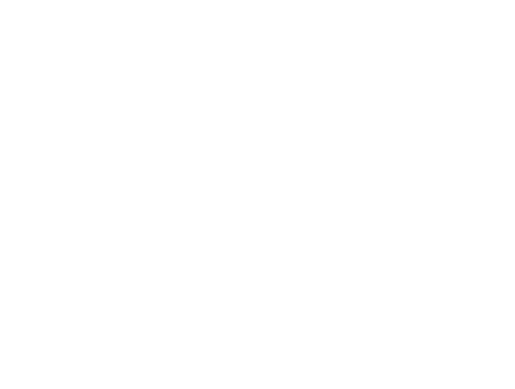

In [9]:
import json, pandas as pd, os, matplotlib.pyplot as plt, IPython.display as disp

OUTDIR = "outputs"
metrics_path = os.path.join(OUTDIR, "metrics.json")
if os.path.exists(metrics_path):
    with open(metrics_path) as f:
        metrics = json.load(f)
    print("ROC AUC:", metrics.get('roc_auc'))
    print("Average Precision:", metrics.get('average_precision'))
    print("Confusion matrix:", metrics.get('confusion_matrix'))
    # pretty print classification report keys for class '1'
    cr = metrics.get('classification_report', {})
    if '1' in cr:
        print("Precision/Recall/F1 for class 1:", {k: cr['1'].get(k) for k in ('precision','recall','f1-score')})
else:
    print("metrics.json not found in", OUTDIR)

# show plots if created
for fn in ['roc_curve.png','pr_curve.png']:
    p = os.path.join(OUTDIR, fn)
    if os.path.exists(p):
        display(plt.imread(p))
        plt.axis('off')
    else:
        print(fn, "not found")

# show top coefficients if available
coef_csv = os.path.join(OUTDIR, 'top_coeffs.csv')
if os.path.exists(coef_csv):
    df_coefs = pd.read_csv(coef_csv)
    display(df_coefs.head(20))
else:
    print("No top_coeffs.csv (feature names might not have been extractable).")
